In [1]:
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [40]:
import os 
import sys
from pycocotools.coco import COCO
import urllib
import zipfile 
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import string
import skimage.io as io 
import math
import re
from tqdm.notebook import tqdm
from collections import Counter
import nltk
nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
os.chdir('/content/drive/My Drive/opt/cocoapi/annotations')
# initialize COCO API for instance annotations
instances_annFile = 'instances_val2017.json'
print(instances_annFile)
coco = COCO(instances_annFile)

# initialize COCO API for caption annotations
captions_annFile = 'captions_val2017.json'
captions_annFile_train = 'captions_train2017.json'
coco_caps = COCO(captions_annFile_train)

# get image ids 
ids = list(coco.anns.keys())
print(ids)
print(len(ids))

instances_val2017.json
loading annotations into memory...
Done (t=2.04s)
creating index...
index created!
loading annotations into memory...
Done (t=1.47s)
creating index...
index created!
[1768, 1773, 2551, 3186, 3419, 3658, 4594, 7544, 7915, 7981, 8032, 9024, 9940, 10176, 12182, 12414, 12582, 13714, 13886, 14105, 14189, 18782, 18979, 19679, 19751, 20026, 20490, 20865, 20979, 21771, 21865, 22328, 22674, 22806, 23289, 23607, 24390, 24776, 24957, 24980, 26036, 26288, 26324, 26341, 26700, 26955, 27423, 27879, 29131, 29249, 29555, 29829, 30246, 30416, 31127, 32126, 33192, 33206, 33253, 33612, 34096, 34111, 34164, 34569, 35170, 36197, 36828, 38591, 38752, 43489, 43705, 46374, 46514, 46653, 46758, 46767, 46947, 46955, 47049, 47170, 47325, 47902, 47906, 47942, 48979, 49229, 49615, 49758, 49884, 49931, 50420, 50497, 50690, 51419, 51451, 51485, 51885, 52282, 52654, 52697, 52709, 52833, 53299, 54220, 54251, 54937, 56874, 57131, 57276, 57569, 57620, 57996, 58138, 58242, 58916, 60301, 60611, 6154

In [20]:
def process_data(paths):
    datadict = {}
    with open(paths, "r") as f:
        json_data = json.load(f)
        images_list = json_data["images"]
        annotations_list = json_data["annotations"]   

    for key in images_list:
        datadict[key["id"]] = {"file_name": key["file_name"], "captions": []}
    for anno in annotations_list:
        datadict[anno["image_id"]]["captions"].append(anno["caption"])
    return datadict

# Number of images that have annos
train_samples = len(process_data('/content/drive/My Drive/opt/cocoapi/annotations/captions_train2017.json'))
train_data = process_data('/content/drive/My Drive/opt/cocoapi/annotations/captions_train2017.json')
print(train_samples)

118287


Img_id:  254814
Img:  [{'license': 3, 'file_name': '000000254814.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000254814.jpg', 'height': 480, 'width': 640, 'date_captured': '2013-11-16 11:56:41', 'flickr_url': 'http://farm1.staticflickr.com/127/373360820_3fc68d5446_z.jpg', 'id': 254814}]
54
Ids of captions of the image:  []


0

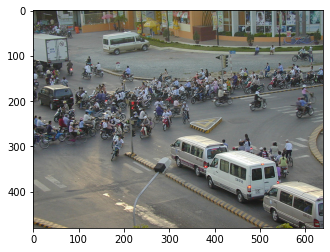

In [21]:
anno_id = np.random.choice(ids)
img_id = coco.anns[anno_id]['image_id']
print('Img_id: ',img_id)
img = coco.loadImgs(img_id)
print('Img: ', img)
image = img[0]['coco_url']
read = io.imread(image)
plt.imshow(read)

print(len(image))
# captions
anno_id = coco_caps.getAnnIds(img_id)
print('Ids of captions of the image: ', anno_id)
anno = coco_caps.loadAnns(anno_id)
coco_caps.showAnns(anno)

In [42]:
def tokenizer(sentence):
    sentence = sentence.lower()
    punctuations = string.punctuation
    result = "".join([w if w not in punctuations and not w.isdigit() else " " for w in sentence])
    tokens = nltk.tokenize.word_tokenize(result)

    return tokens
sentence = 'I. , . love you so much babe'
print(tokenizer(sentence))

['i', 'love', 'you', 'so', 'much', 'babe']


In [43]:
class Annotation:
    def __init__(self, train_data, tokenizer):
        self.train_data = list(train_data.values())
        self.tokenizer = tokenizer
        self.count_words = [Counter(), Counter(), Counter(), Counter(), Counter()]
        self.caption_list = self.caption_init()
    
    def __len__(self):
        return len(self.train_data)

    def caption_init(self):
        caption_list = []
        for i in tqdm(range(len(self.train_data))):
            captions = self.train_data[i]['captions']
            for id, caps in enumerate(captions):
                if id >= len(caption_list):
                    caption_list.append([caps])
                else:
                    caption_list[id].append(caps)
        
        return caption_list

    def count_freq(self, idx = None):
        assert idx == None or (idx>=0 and idx<=4), 'Must between 0 and 4'
        if idx is None:
            all_idx = Counter()
            for i in range(5):
                all_idx += self.count_freq(idx = i)
            return all_idx
        else:
            captions_list = self.caption_list[idx]
        
        if len(self.count_words[idx]) == 0:
            print(self.count_words)
            for caption in tqdm(captions_list):
                tokens = self.tokenizer(caption)
                self.count_words[idx].update(tokens)
        
        return self.count_words[idx]
    
    def visualize_top_words(self, idx = None, k = 5):
        count_dict = self.count_freq(idx = idx)
        top_k = count_dict.most_common(k)
        
        words = [word[0] for word in top_k]
        freqs = [freq[1] for freq in top_k]
        fig, ax = plt.subplots(figsize = (15, 10))
        y_pos = np.arange(len(words))
        rgb = np.random.rand(3,)
        
        ax.barh(y_pos, freqs, align = 'center', color = [rgb])
        ax.set_yticks(y_pos)
        ax.set_yticklabels(words, fontsize = 18, fontweight = 'bold')
        ax.invert_yaxis()
        
        ax.set_xlabel('Frequency', fontsize = 18)
        ax.set_title(f'Top {k} words in annotation',fontsize= 20)
        
        plt.show()


[Counter(), Counter(), Counter(), Counter(), Counter()]



[Counter({'a': 205723, 'of': 45413, 'on': 43185, 'the': 34475, 'in': 34459, 'with': 30356, 'and': 25942, 'is': 16599, 'to': 15644, 'man': 15640, 'sitting': 13163, 'standing': 10387, 'next': 10359, 'an': 9025, 'two': 9010, 'white': 8394, 'people': 8189, 'at': 7569, 'woman': 7186, 'top': 6975, 'are': 6890, 'table': 6557, 'holding': 6530, 'street': 6180, 'that': 5526, 'it': 5359, 'large': 5309, 'group': 5067, 'down': 5062, 'field': 4929, 'person': 4816, 'riding': 4755, 'some': 4288, 'up': 4078, 'tennis': 4046, 'front': 3933, 'young': 3930, 'black': 3894, 'plate': 3857, 'small': 3852, 'train': 3852, 'red': 3755, 'dog': 3692, 'near': 3678, 'room': 3640, 'cat': 3404, 'his': 3311, 'baseball': 3270, 'walking': 3187, 'green': 3120, 'water': 3057, 'while': 3031, 'couple': 2985, 'by': 2983, 'blue': 2970, 'food': 2877, 'bathroom': 2828, 'sign': 2822, 'side': 2816, 'playing': 2706, 'grass': 2700, 'kitchen': 2698, 'other': 2694, 'snow': 2630, 'parked': 2610, 'building': 2598, 'pizza': 2564, 'bus': 


[Counter({'a': 205723, 'of': 45413, 'on': 43185, 'the': 34475, 'in': 34459, 'with': 30356, 'and': 25942, 'is': 16599, 'to': 15644, 'man': 15640, 'sitting': 13163, 'standing': 10387, 'next': 10359, 'an': 9025, 'two': 9010, 'white': 8394, 'people': 8189, 'at': 7569, 'woman': 7186, 'top': 6975, 'are': 6890, 'table': 6557, 'holding': 6530, 'street': 6180, 'that': 5526, 'it': 5359, 'large': 5309, 'group': 5067, 'down': 5062, 'field': 4929, 'person': 4816, 'riding': 4755, 'some': 4288, 'up': 4078, 'tennis': 4046, 'front': 3933, 'young': 3930, 'black': 3894, 'plate': 3857, 'small': 3852, 'train': 3852, 'red': 3755, 'dog': 3692, 'near': 3678, 'room': 3640, 'cat': 3404, 'his': 3311, 'baseball': 3270, 'walking': 3187, 'green': 3120, 'water': 3057, 'while': 3031, 'couple': 2985, 'by': 2983, 'blue': 2970, 'food': 2877, 'bathroom': 2828, 'sign': 2822, 'side': 2816, 'playing': 2706, 'grass': 2700, 'kitchen': 2698, 'other': 2694, 'snow': 2630, 'parked': 2610, 'building': 2598, 'pizza': 2564, 'bus': 


[Counter({'a': 205723, 'of': 45413, 'on': 43185, 'the': 34475, 'in': 34459, 'with': 30356, 'and': 25942, 'is': 16599, 'to': 15644, 'man': 15640, 'sitting': 13163, 'standing': 10387, 'next': 10359, 'an': 9025, 'two': 9010, 'white': 8394, 'people': 8189, 'at': 7569, 'woman': 7186, 'top': 6975, 'are': 6890, 'table': 6557, 'holding': 6530, 'street': 6180, 'that': 5526, 'it': 5359, 'large': 5309, 'group': 5067, 'down': 5062, 'field': 4929, 'person': 4816, 'riding': 4755, 'some': 4288, 'up': 4078, 'tennis': 4046, 'front': 3933, 'young': 3930, 'black': 3894, 'plate': 3857, 'small': 3852, 'train': 3852, 'red': 3755, 'dog': 3692, 'near': 3678, 'room': 3640, 'cat': 3404, 'his': 3311, 'baseball': 3270, 'walking': 3187, 'green': 3120, 'water': 3057, 'while': 3031, 'couple': 2985, 'by': 2983, 'blue': 2970, 'food': 2877, 'bathroom': 2828, 'sign': 2822, 'side': 2816, 'playing': 2706, 'grass': 2700, 'kitchen': 2698, 'other': 2694, 'snow': 2630, 'parked': 2610, 'building': 2598, 'pizza': 2564, 'bus': 


[Counter({'a': 205723, 'of': 45413, 'on': 43185, 'the': 34475, 'in': 34459, 'with': 30356, 'and': 25942, 'is': 16599, 'to': 15644, 'man': 15640, 'sitting': 13163, 'standing': 10387, 'next': 10359, 'an': 9025, 'two': 9010, 'white': 8394, 'people': 8189, 'at': 7569, 'woman': 7186, 'top': 6975, 'are': 6890, 'table': 6557, 'holding': 6530, 'street': 6180, 'that': 5526, 'it': 5359, 'large': 5309, 'group': 5067, 'down': 5062, 'field': 4929, 'person': 4816, 'riding': 4755, 'some': 4288, 'up': 4078, 'tennis': 4046, 'front': 3933, 'young': 3930, 'black': 3894, 'plate': 3857, 'small': 3852, 'train': 3852, 'red': 3755, 'dog': 3692, 'near': 3678, 'room': 3640, 'cat': 3404, 'his': 3311, 'baseball': 3270, 'walking': 3187, 'green': 3120, 'water': 3057, 'while': 3031, 'couple': 2985, 'by': 2983, 'blue': 2970, 'food': 2877, 'bathroom': 2828, 'sign': 2822, 'side': 2816, 'playing': 2706, 'grass': 2700, 'kitchen': 2698, 'other': 2694, 'snow': 2630, 'parked': 2610, 'building': 2598, 'pizza': 2564, 'bus': 

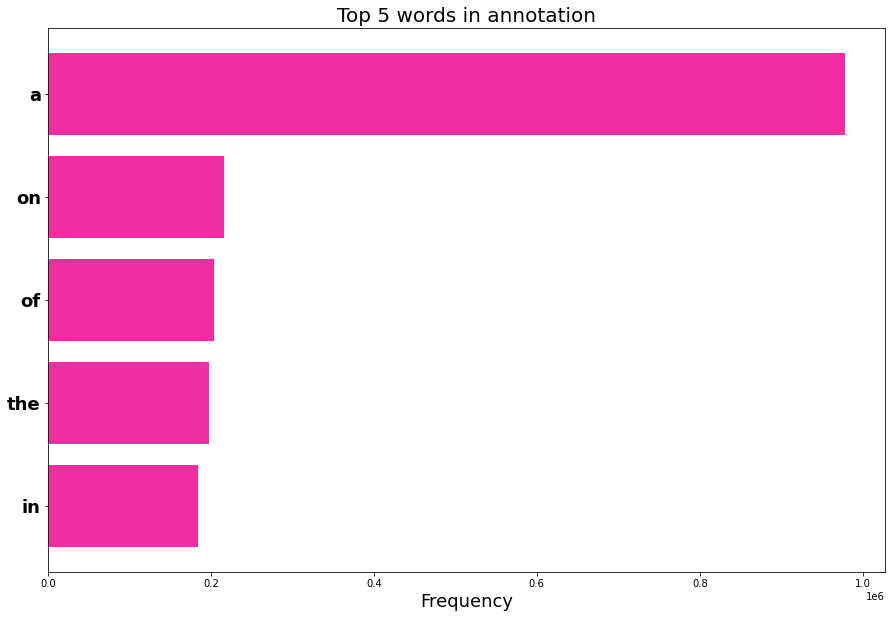

In [44]:
anno = Annotation(train_data, tokenizer)
anno.visualize_top_words(k = 5)